In [1]:
import pandas as pd
import numpy as np
#from subprocess import call
from numpy import arange 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.collections as collections
import matplotlib.gridspec as gridspec
import os
import csv
import scipy.misc
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
from keras.layers import Dense,Input,Activation,Dropout,Conv2D,Convolution2D,MaxPooling2D,Flatten,Lambda,ELU
from keras.optimizers import Adam
from keras.models import model_from_json
#from keras.layers import Conv2D, Flatten, Dropout, MaxPooling2D, Lambda
from keras.models import Sequential, load_model
#from keras.layers import Dense, Input, Activation
from keras.callbacks import EarlyStopping
import json
import h5py
from keras.models import load_model

%matplotlib inline

Using TensorFlow backend.


In [2]:
matplotlib.style.use('ggplot')

data_dir = './data/'
data_csv = 'driving_log.csv'
model_json = 'model.json'
model_weights = 'model.h5'

#col_names = ['center', 'left','right','steering','throttle','brake','speed']
record_data = pd.read_csv(data_dir+data_csv,names=None)
record_data.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [3]:
left = record_data['left']
center = record_data['center']
right = record_data['right']
steering = record_data['steering']
steering = steering.astype(np.float32)
#print (center[:10])
#print (steering[70:100])
left.head(), steering.head()

(0     IMG/left_2016_12_01_13_30_48_287.jpg
 1     IMG/left_2016_12_01_13_30_48_404.jpg
 2     IMG/left_2016_12_01_13_31_12_937.jpg
 3     IMG/left_2016_12_01_13_31_13_037.jpg
 4     IMG/left_2016_12_01_13_31_13_177.jpg
 Name: left, dtype: object, 0    0.0
 1    0.0
 2    0.0
 3    0.0
 4    0.0
 Name: steering, dtype: float32)

In [4]:
center = []
left = []
right = []
steering = []
steering_left = []
steering_right = []
throttle = []
brake = []
speed = []

#read drivinglog.csv
with open(data_dir+data_csv) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        center.append(row['center'].split('IMG')[1])
        left.append(row['left'].split('IMG')[1])
        right.append(row['right'].split('IMG')[1])
        steering.append(float(row['steering']))
        #steering_left.append(float(row['steering'])+0.25)
        #steering_right.append(float(row['steering'])-0.25)
        throttle.append(float(row['throttle']))
        brake.append(float(row['brake']))
        speed.append(float(row['speed']))
print (center[1])
print (left[1])
print (right[1])

/center_2016_12_01_13_30_48_404.jpg
/left_2016_12_01_13_30_48_404.jpg
/right_2016_12_01_13_30_48_404.jpg


In [5]:
#Apply 60 frame moving average to steering records 
smooth = []
smooth_l = []
smooth_r = []
moving_range = 60
moving_avg = arange(-1,1,2/moving_range) 
print (len(moving_avg))

for i in range(len(steering)):
    j = i%moving_range
    moving_avg[j] = steering[i]
    smooth.append(np.mean(moving_avg)*2)
    smooth_l.append(np.mean(moving_avg)*2+0.1)
    smooth_r.append(np.mean(moving_avg)*2-0.1)

60


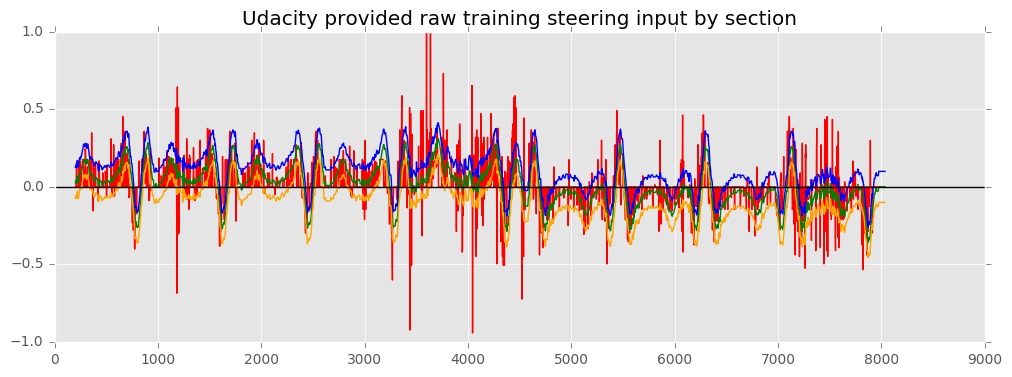

In [6]:
#Plot the steering angle for each frame, show the section form 200 to the end.
#Overall, the steering range from -1 to 1. 
#Somehow, the steering input is not smooth, I will further investagate into it. 
#

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as collections


t = np.arange(0.0, len(center), 1)[200:]

fig, ax = plt.subplots(figsize =(12,4))
ax.set_title('Udacity provided raw training steering input by section')
ax.plot(t, steering[200:], color='red')
ax.plot(t, smooth[200:], color='green')
ax.plot(t, smooth_l[200:], color='blue')
ax.plot(t, smooth_r[200:], color='orange')
ax.axhline(0, color='black', lw=1)


plt.show()

In [7]:
print('Merge Left, Center and Right Camera image together...')

X_all = np.concatenate((center, left, right), axis = 0)
y_all = np.concatenate((smooth, smooth_l, smooth_r), axis = 0)

print('Merge completed. Number of total samples', len(y_all))

Merge Left, Center and Right Camera image together...
Merge completed. Number of total samples 24108


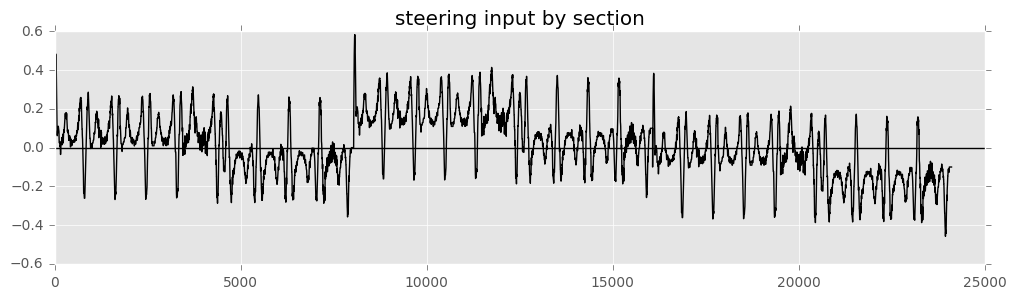

In [8]:
### 
f = np.arange(0.0, len(y_all), 1)

fig, ax = plt.subplots(figsize =(12,3))
ax.set_title('steering input by section')
ax.plot(f, y_all, color='black')
ax.axhline(0, color='black', lw=1)


plt.show()

In [9]:
X_all, y_all = shuffle(X_all, y_all)

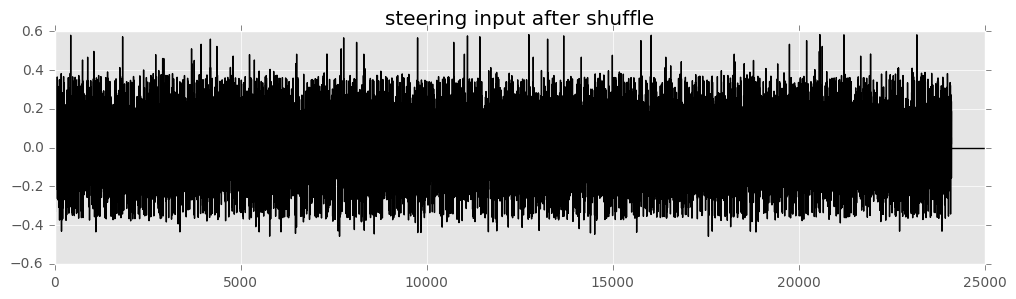

In [10]:
### 
f = np.arange(0.0, len(y_all), 1)

fig, ax = plt.subplots(figsize =(12,3))
ax.set_title('steering input after shuffle')
ax.plot(f, y_all, color='black')
ax.axhline(0, color='black', lw=1)


plt.show()

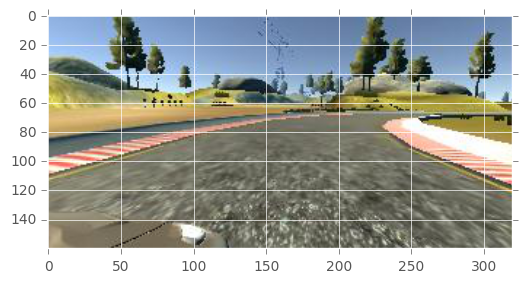

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

img_path = './data/IMG/'
#reading in an image
index = np.random.randint(1,len(X_all))
img = scipy.misc.imread(img_path+X_all[index])
#printing out some stats and plotting
#print('This image is:', type(image), 'with dimesions:', image.shape)
#plt.imshow(image1) 
plt.imshow(img) 

In [27]:
### Define some help functions: 
def flip_image(img):
    img_flip = cv2.flip(img,1)
    #angle_flip = -angle
    return img_flip

def dark_image(img):
    img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    img[:,:,2] = img[:,:,2]*np.random.uniform(0.1,1.2)
    dst = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    return dst

def trans_image(img,steer,trans_range):
    # Translation
    tr_x = np.random.uniform()-0.5
    steer_ang = steer + tr_x/trans_range
    tr_y = np.random.uniform()-0.5
    rows,cols,ch = img.shape
    Trans_M = np.float32([[1,0,tr_x*140],[0,1,tr_y*50]])
    image_tr = cv2.warpAffine(img,Trans_M,(cols,rows))
    return image_tr,steer_ang

def mask_image(img):
    """
    Applies an image mask.
    region_of_interest(img, vertices):
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    #mask = np.zeros_like(img)
    #image1 = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    #image = mpimg.imread('data/'+X_all[index])
    rows,cols,ch = img.shape
    ax = int(cols*(np.random.uniform(-0.5,0.5)))
    #+y_all[np.random.uniform(100,8000)])
    bx = int(ax+cols*np.random.uniform(-0.5,0.5))
    #cx = int(cols*np.random.uniform(-1,1)+cols*np.random.uniform(-0.5,0.5))
    #dx = int(cx+cols*np.random.uniform())
    #ax = 100+y_all[np.random.uniform(100,8000)]
    #bx = 200
    cx = int(np.random.uniform(0, 160))
    dx = int(cols-cx)
    p = (np.random.uniform(-0.5,0.5))
    #vertices = np.array([[(p*cols,rows),(ax,int(p*rows)), (bx, int(p*rows)), (cols*(1+p),rows)]], dtype=np.int32)
    vertices = np.array([[(dx,rows),(ax,int(p*rows)), (bx, int(p*rows)), (cx,rows)]], dtype=np.int32)
       
    shadow = np.random.randint(1, 128)
    mask = np.full_like(img, shadow)
        
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

def crop_image(img, angle):
    center_row = 80
    center_col = 160
    width = 200
    height = 66
    
    x_var = int(np.random.uniform(-20,20))
    y_var = int(np.random.uniform(-10,10))
    
    crop_img = img[int(center_row-height/2+y_var):int(center_row+height/2+y_var),
                  int(center_col-width/2+x_var):int(center_col+width/2+x_var)]
    
    angle_factor = 0.002 # degree per each shifted pixel
    adj_angle = angle + angle_factor*y_var
    
    return crop_img, adj_angle
    
def plot_random_image(n_row,n_col,data_dir,X,y):

    plt.figure(figsize = (2.5*n_col,1.2*n_row))
    gs1 = gridspec.GridSpec(n_row,n_col)
    gs1.update(wspace=0.1, hspace=0.2) # set the spacing between axes. 

    for i in range(n_row*n_col):
        ax1 = plt.subplot(gs1[i])
        index = np.random.randint(1,len(y))
        img = mpimg.imread(img_path+X[index])
        dark_img = dark_image(img)
        masked_img = mask_image(dark_img)
        cropped_img,adj_angle = crop_image(masked_img,y[index])
        if i%2 ==1:
            plt.imshow(flip_image(cropped_img))
            plt.title(str(np.round(adj_angle,5)),fontsize=8)
            plt.axis('off')
        if i%2 ==0:
            plt.imshow(cropped_img)
            plt.title(str(np.round(adj_angle,5)),fontsize=8)
            plt.axis('off')
                
    plt.show()
     
def LoadTrainBatchGen(batch_size):
    while True:
        global train_batch_pointer
        x_out = []
        y_out = []
        for i in range(0, batch_size):
            x_out.append(scipy.misc.imresize(mpimg.imread(img_path+train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [64, 64]) / 255.0)
            y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
        train_batch_pointer += batch_size
        if train_batch_pointer >=num_train_images:
            break
        yield np.array(x_out), np.array(y_out)

def LoadValBatchGen(batch_size):
    while True:
        global val_batch_pointer
        x_out = []
        y_out = []
        for i in range(0, batch_size):
            x_out.append(scipy.misc.imresize(scipy.misc.imread(img_path+val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [64, 64]) / 255.0)
            y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
        val_batch_pointer += batch_size
        if val_batch_pointer >=num_val_images:
            break
        yield np.array(x_out), np.array(y_out)

def LoadTrainBatchGenerator(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        img =mpimg.imread(img_path+train_xs[(train_batch_pointer + i) % num_train_images])
        angle = train_ys[(train_batch_pointer + i) % num_train_images]
        dark_img = dark_image(img)
        masked_img = mask_image(dark_img)
        cropped_img,adj_angle = crop_image(masked_img,angle)
        if i%2 ==1:
            x_out.append(flip_image(cropped_img)/255.0)
            #x_out.append(flip_image(masked_img)/255.0)
            y_out.append([-adj_angle])
        if i%2 ==0:
            x_out.append((cropped_img)/255.0)
            #x_out.append(scipy.misc.imresize(cropped_img, [66, 200]) / 255.0)
            y_out.append([adj_angle])
    train_batch_pointer += batch_size
    return np.array(x_out).astype('float32'), np.array(y_out).astype('float32')

def LoadValBatchGenerator(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        img =mpimg.imread(img_path+val_xs[(val_batch_pointer + i) % num_val_images])
        angle = val_ys[(val_batch_pointer + i) % num_val_images]
        dark_img = dark_image(img)
        masked_img = mask_image(dark_img)
        cropped_img,adj_angle = crop_image(masked_img,angle)
        if i%2 ==1:
            x_out.append(flip_image(cropped_img)/255.0)
            y_out.append([-adj_angle])
        if i%2 ==0:
            x_out.append((cropped_img)/255.0)
            #x_out.append(scipy.misc.imresize(cropped_img, [66, 200]) / 255.0)
            y_out.append([adj_angle])
    val_batch_pointer += batch_size
    return np.array(x_out).astype('float32'), np.array(y_out).astype('float32')

In [13]:

train_xs = X_all[:int(len(X_all) * 0.8)]
train_ys = y_all[:int(len(y_all) * 0.8)]

val_xs = X_all[-int(len(X_all) * 0.2):]
val_ys = y_all[-int(len(y_all) * 0.2):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

In [14]:
print (num_train_images)
print (num_val_images)

19286
4821


In [15]:
###xs, ys = LoadTrainBatchGenerator(100)
xs, ys = LoadTrainBatchGenerator(batch_size)

X_train = xs
y_train = ys

X_val, y_val = LoadValBatchGenerator(batch_size)

print('Number of training samples and size', X_train.shape)
print('Number of training samples and size', y_train.shape)
print('Number of val samples and size', X_val.shape)
print('Number of val samples and size', y_val.shape)

#print (xs[0])
#print (ys)

Number of training samples and size (256, 66, 200, 3)
Number of training samples and size (256, 1)
Number of val samples and size (256, 66, 200, 3)
Number of val samples and size (256, 1)


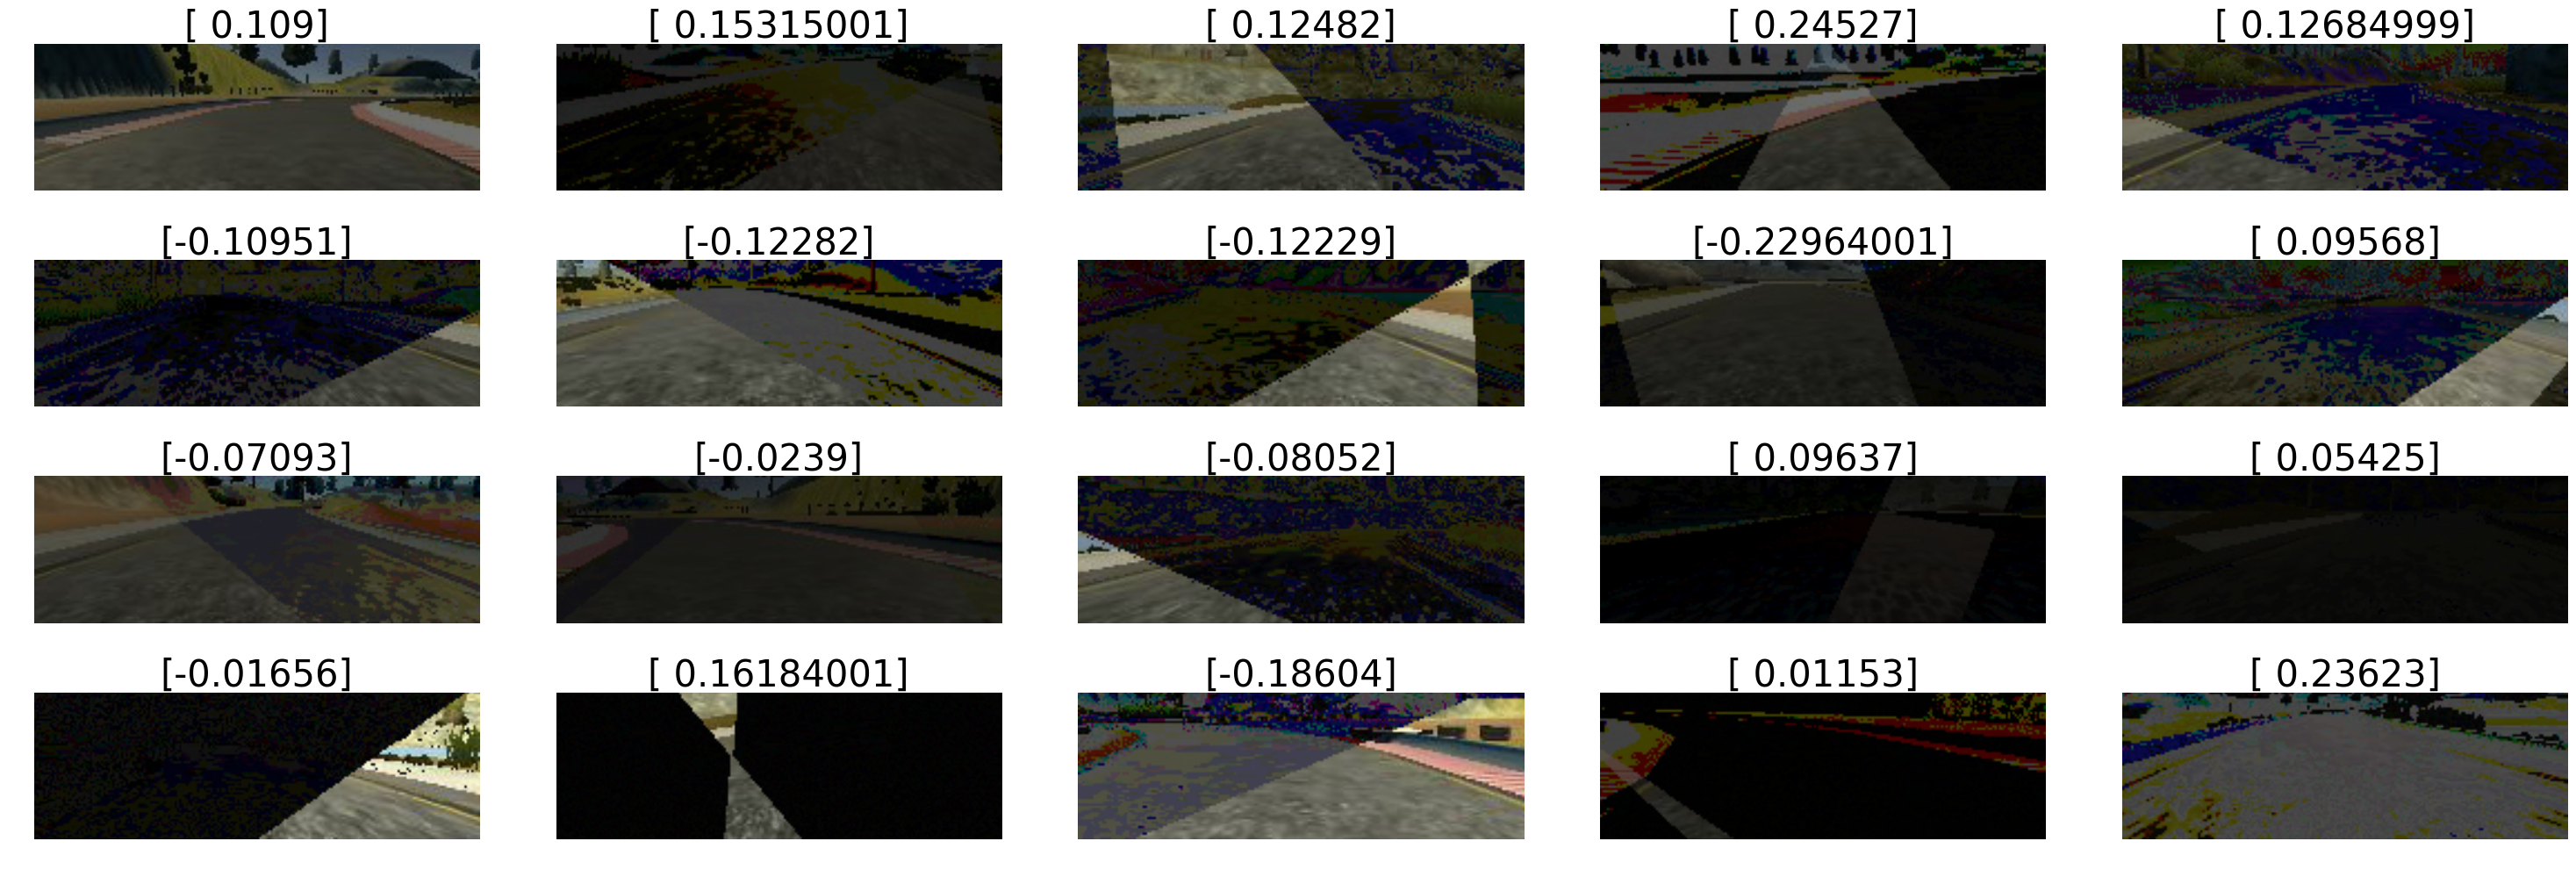

In [48]:
plt.rcParams['figure.figsize']=[30,10]
for i in range(0,20):
    plt.subplot(4,5,i+1)
    plt.tight_layout()
    plt.axis('off')
    index = np.random.randint(1,20)
    plt.title(str(np.round(ys[i],5)),fontsize=30)
    #plt.imshow(mpimg.imread('data/'+X_all[index]))
    plt.imshow(xs[i])

ploting random images in train dataset......


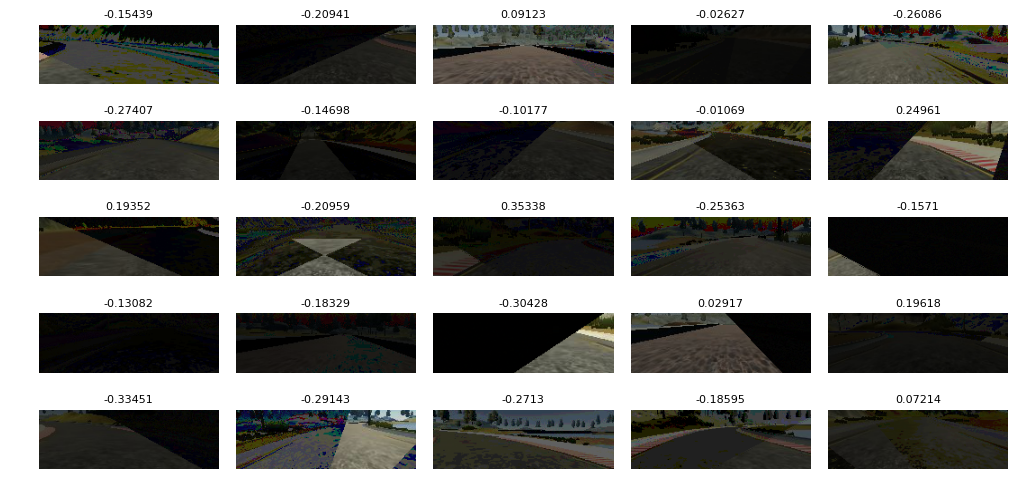

In [24]:
print('ploting random images in train dataset......')
plot_random_image(5,5,data_dir,X_all,y_all)

In [30]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

print('Build a Nvida convolution neural network with Keras here.')
#from keras.layers import Conv2D, Flatten, Dropout, MaxPooling2D, Lambda
#from keras.models import Sequential, load_model
#from keras.layers import Dense, Input, Activation
#from keras.callbacks import EarlyStopping
earlystop= EarlyStopping(min_delta= 0.008, patience= 2, verbose=1)

keep_prob = 0.5
batch_size = 256
input_shape = (64, 64, 3) # 3@64x64
learning_rate = 0.001

model = Sequential()
model.add(Lambda(lambda x: x/127.5 -1,input_shape=(64,64,3)))
model.add(Conv2D(24, 5, 5, input_shape=input_shape, border_mode='same',activation='relu', subsample=(2, 2)))
#model.add(activation='relu')
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Conv2D(36, 5, 5, input_shape=input_shape, border_mode='same',activation='relu', subsample=(2, 2)))
#model.add(activation='relu')
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Conv2D(48, 5, 5, input_shape=input_shape, border_mode='same',activation='relu', subsample=(2, 2)))
#model.add(ELU())
#model.add(activation='relu')
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
#model.add(Dropout(keep_prob))
model.add(Conv2D(64, 3, 3, input_shape=input_shape, border_mode='same',activation='relu', subsample=(1, 1)))
#model.add(ELU())
#model.add(activation='relu')
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Conv2D(64, 3, 3, input_shape=input_shape, border_mode='same',activation='relu', subsample=(1, 1)))
#model.add(ELU())
#model.add(activation='relu')
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Flatten())
#model.add(Dropout(keep_prob))
model.add(Dense(512,activation='relu'))
#model.add(activation='relu')
#model.add(ELU())
model.add(Dense(100,activation='relu'))
#model.add(activation='relu')
#model.add(ELU())
model.add(Dense(50,activation='relu'))
#model.add(activation='relu')
#model.add(ELU())
model.add(Dense(10,activation='relu'))
#model.add(activation='relu')
#model.add(ELU())
model.add(Dense(1))
#model.add(ELU())

#adam = Adam(lr=0.001)

model.summary()
# Compile and train the model here.
#model.compile(loss='categorical_crossentropy',
#              optimizer='adam',
#              metrics=['accuracy'])
model.compile(loss='mse', optimizer=Adam(learning_rate),metrics=['accuracy'])

Build a Nvida convolution neural network with Keras here.
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_7 (Lambda)                (None, 64, 64, 3)     0           lambda_input_7[0][0]             
____________________________________________________________________________________________________
convolution2d_26 (Convolution2D) (None, 32, 32, 24)    1824        lambda_7[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_24 (MaxPooling2D)   (None, 31, 31, 24)    0           convolution2d_26[0][0]           
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 16, 16, 36)    21636       maxpooling2d_24[0][0]            
_________________________________

In [20]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Model saved.")

Model saved.


In [28]:
batch_size = 20
rnd_indices = np.random.randint(0, num_train_images, batch_size)

print (rnd_indices)

[ 5132 18578 13428  8654  6287 15943  7483 12142 16955 15521 10091  1034
 12113  2189 18240  6875  4632  9286   715 11027]


In [32]:
def get_image_files_loop(batch_size, num_of_img):
    """
    The simulator records three images (namely: left, center, and right) at a given time
    However, when we are picking images for training we randomly (with equal probability)
    one of these three images and its steering angle.
    :param batch_size:
        Size of the image batch
    :return:
        An list of selected (image files names, respective steering angles)
    """
    #data = pd.read_csv(DRIVING_LOG_FILE)
    #num_of_img = len(data)
    rnd_indices = np.random.randint(0, num_of_img, batch_size)

    img_batch = []
    for index in rnd_indices:
        img_batch.append((X_all[index],y_all[index]))

    return img_batch

print (get_image_files_loop(batch_size,num_train_images))


[('/center_2016_12_01_13_38_14_863.jpg', -0.145209109), ('/center_2016_12_01_13_37_42_880.jpg', 0.03662101999999999), ('/right_2016_12_01_13_37_13_940.jpg', -0.032440672000000004), ('/right_2016_12_01_13_33_21_808.jpg', -0.065365028000000019), ('/right_2016_12_01_13_40_57_965.jpg', 0.16088674900000002), ('/right_2016_12_01_13_38_00_553.jpg', 0.16681596733333329), ('/center_2016_12_01_13_33_05_802.jpg', 0.1423095713333333), ('/left_2016_12_01_13_44_23_510.jpg', 0.060440980566666677), ('/right_2016_12_01_13_40_05_910.jpg', -0.089655045666666669), ('/center_2016_12_01_13_42_54_739.jpg', -0.036077753766666665), ('/right_2016_12_01_13_38_21_342.jpg', 0.15173881666666664), ('/center_2016_12_01_13_41_59_341.jpg', -0.030866322999999998), ('/right_2016_12_01_13_45_17_456.jpg', -0.21957153033333332), ('/center_2016_12_01_13_39_31_169.jpg', 0.013183995700000003), ('/center_2016_12_01_13_37_39_947.jpg', 0.046286255533333341), ('/left_2016_12_01_13_38_27_712.jpg', 0.11883542533333336), ('/right_201

In [36]:
def LoadTrainBatchGenerator(batch_size):
    
    while True:
        #global train_batch_pointer
        x_out = []
        y_out = []
        images = get_image_files_loop(batch_size,num_train_images)
        for img_file,angle in images:
            #img =mpimg.imread(img_path+train_xs[(train_batch_pointer + i) % num_train_images])
            #angle = train_ys[(train_batch_pointer + i) % num_train_images]
            img = plt.imread(img_path+img_file)
            dark_img = dark_image(img)
            masked_img = mask_image(dark_img)
            cropped_img,adj_angle = crop_image(masked_img,angle)
            if i%2 ==1:
                x_out.append(flip_image(cropped_img)/255.0)
                #x_out.append(flip_image(masked_img)/255.0)
                y_out.append([-adj_angle])
            if i%2 ==0:
                x_out.append((cropped_img)/255.0)
                #x_out.append(scipy.misc.imresize(cropped_img, [66, 200]) / 255.0)
                y_out.append([adj_angle])
        assert len(x_out) == batch_size, 'len(x_out) == batch_size should be True'
        #train_batch_pointer += batch_size
        yield np.array(x_out).astype('float32'), np.array(y_out).astype('float32')

In [332]:
model.fit(X_train, y_train, batch_size=256, nb_epoch=10, verbose=2, validation_data=(X_val,y_val))

Train on 10000 samples, validate on 256 samples
Epoch 1/10
51s - loss: 0.0410 - acc: 4.0000e-04 - val_loss: 0.0232 - val_acc: 0.0000e+00
Epoch 2/10
50s - loss: 0.0247 - acc: 4.0000e-04 - val_loss: 0.0228 - val_acc: 0.0000e+00
Epoch 3/10
50s - loss: 0.0243 - acc: 4.0000e-04 - val_loss: 0.0232 - val_acc: 0.0000e+00
Epoch 4/10
50s - loss: 0.0238 - acc: 4.0000e-04 - val_loss: 0.0222 - val_acc: 0.0000e+00
Epoch 5/10
50s - loss: 0.0234 - acc: 4.0000e-04 - val_loss: 0.0231 - val_acc: 0.0000e+00
Epoch 6/10
50s - loss: 0.0234 - acc: 4.0000e-04 - val_loss: 0.0219 - val_acc: 0.0000e+00
Epoch 7/10
50s - loss: 0.0232 - acc: 4.0000e-04 - val_loss: 0.0218 - val_acc: 0.0000e+00
Epoch 8/10
50s - loss: 0.0231 - acc: 4.0000e-04 - val_loss: 0.0222 - val_acc: 0.0000e+00
Epoch 9/10
50s - loss: 0.0231 - acc: 4.0000e-04 - val_loss: 0.0218 - val_acc: 0.0000e+00
Epoch 10/10
50s - loss: 0.0232 - acc: 4.0000e-04 - val_loss: 0.0220 - val_acc: 0.0000e+00


In [28]:
# TODO: Re-construct the network and add dropout after the pooling layer.
from keras.layers import Dropout

model = Sequential()
model.add(Conv2D(32, 3, 3, input_shape=(64, 64, 3)))
model.add(MaxPooling2D((3,3)))
model.add((Dropout(0.3)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()
# TODO: Compile and train the model here.
model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_25 (Convolution2D) (None, 62, 62, 32)    896         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
maxpooling2d_23 (MaxPooling2D)   (None, 20, 20, 32)    0           convolution2d_25[0][0]           
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 20, 20, 32)    0           maxpooling2d_23[0][0]            
____________________________________________________________________________________________________
activation_3 (Activation)        (None, 20, 20, 32)    0           dropout_3[0][0]                  
___________________________________________________________________________________________

In [32]:
number_of_epochs = 8
batch_size = 256

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

train_gen = LoadTrainBatchGen(batch_size)
val_gen = LoadValBatchGen(batch_size)

history = model.fit_generator(train_gen, 
                              samples_per_epoch=num_train_images,
                              nb_epoch=number_of_epochs,
                              validation_data=val_gen,
                              nb_val_samples=num_val_images, verbose=1)

Epoch 1/8
19200/19286 [============================>.] - ETA: 0s - loss: 0.0245 - acc: 0.0032

Exception in thread Thread-19:
Traceback (most recent call last):
  File "/home/tfbox/anaconda3/envs/carnd-term1/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/tfbox/anaconda3/envs/carnd-term1/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tfbox/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py", line 404, in data_generator_task
    generator_output = next(generator)
StopIteration



Exception: output of generator should be a tuple (x, y, sample_weight) or (x, y). Found: None

In [39]:
import h5py
from keras.models import load_model

#model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

OSError: Unable to open file (Unable to open file: name = 'my_model.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [ ]:
json_string = model.to_json()
with open(model_json, 'w') as outfile:
    json.dump(json_string, outfile)
model.save_weights(model_weights)